# P Export by Subwatershed

Below is the Python script used for running the P export by upstream sub watershed for the manuscript, "Data Analytics Framework for Mining and Mapping Legacy Nutrient Pollution to Waterbodies and Effect on Cyanobacteria Harmful Algal Blooms". For the analysis in the manuscript, we used the following packages (version in parentheses) using Python 3.8.5:

 * numpy (1.19.2)
 * pandas (1.4.2)
 * matplotlib (3.5.2)
 * scipy (1.5.2)
 * geopandas (0.8.2)
 * shapely (1.7.1)
 * networkx (2.5)
 
We also used "HydroGraphs" from the work of Cole et al. available [here](https://github.com/zavalab/ML/tree/master/HydroGraphs).

### Import necessary packages

In [7]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from scipy.stats import iqr
import os

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors as colors
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import geopandas
import geopandas as gpd
from geopandas.tools import sjoin

from shapely.geometry import Point

import datetime

from tqdm import tqdm
import networkx as nx

from HydroGraph_functions import *

## 1. Clean up Flow Data
In the subsection below, we show how we curate the data containing the flow rate and total phosphorus concentration at different stations. 

In [8]:
station_data = pd.read_csv("station_data.csv")
flow_data = pd.read_csv("stream_data.csv")

YRivers       = pd.read_pickle("yahara_data/YRivers.df")
YLakes        = pd.read_pickle("yahara_data/YLakes.df")
Yhuc8         = pd.read_pickle("yahara_data/YHUC8.df")
Yhuc10        = pd.read_pickle("yahara_data/YHUC10.df")
Yhuc12        = pd.read_pickle("yahara_data/YHUC12.df")
Ycatch        = pd.read_pickle("yahara_data/Ycatch.df")
Ylc           = pd.read_pickle("yahara_data/Ylc.df")
Yhu_gdf       = pd.read_pickle("yahara_data/Yhu.df")
Yintdrain_gdf = pd.read_pickle("yahara_data/Yintdrain.df")

In [9]:
# WItofroms can be found in the WItofroms.csv file here: 
# https://github.com/zavalab/ML/tree/master/HydroGraphs/graph_construction/WIgeodataframes
WItofroms = pd.read_csv("WItofroms.csv", index_col = 0)

# The NHDPlusV2 data is missing a fromCOMID/toCOMID pairing
# we manually add this pairing.
new_line = [np.nan for i in range(len(WItofroms.columns))]
new_line[0] = 13293430
new_line[3] = 13293456

WItofroms = WItofroms.append(pd.Series(new_line, index = WItofroms.columns), ignore_index = True)

# Build the NetworkX graph from the list of to-from COMID pairings
graph = build_graph(WItofroms)

In [10]:
# Define constants that will be used later
ID    = "MonitoringLocationIdentifier" # Station ID name in dataframe
huc10s = [709000205, 709000206] # HUC10s for Yahara watersheds
buffer_list = [5, 10, 20, 50, 100, 200] # list of buffer sizes to use for matching COMIDs to rivers

# Get a list of the unique station IDs in the flow data
station_ids = np.unique(flow_data.ID.values)
# get the station_data that corresponds to the above station IDs
station_data = station_data[station_data[ID].isin(station_ids)]

# Turn the station data into a GeoDataFrame
x_y_points = gpd.points_from_xy(station_data.LongitudeMeasure.values, station_data.LatitudeMeasure.values)
station_gdf = gpd.GeoDataFrame(station_data, geometry = x_y_points)
station_gdf = station_gdf.set_crs("EPSG:4326")

In [11]:
# Define a function for matching the station location points to NHDPlusV2 flowlines
# This adds the COMID identifier to the station GeoDataFrame; called by add_COMIDs function below
def match_to_river(station_gdf, river_gdf, buffer_size, river_gdf_m):
    
    # build a new GeoDataFrame where the flowlines have a buffer around them
    # buffer_size comes from the buffer_list in the cell above; 
    # in units of meters if the river_gdf_m DataFrame is set correctly
    buffers = river_gdf_m.buffer(buffer_size, cap_style=2)
    buffers = buffers.to_crs("EPSG:4326")
    
    # Loop through the stations, and test whether the station location lands in the buffer
    # for any given flowline; if it does, add the flowline COMID to the station GeoDataFrame
    for i in tqdm(range(len(station_gdf))):        
        if station_gdf.COMID.iloc[i] == 0:
            point = station_gdf.geometry.iloc[i]
            for j in range(len(buffers)):
                if point.within(buffers.geometry.iloc[j]):
                    station_gdf.COMID.iloc[i] = river_gdf_m.COMID.iloc[j]
                    break
    return station_gdf


# Matches river flowline COMIDs to the station GeoDataFrame. EPSG is a string that converts
# the crs of the rivers (for Wisconsin, EPSG:3071 converts to units of meters); this is
# used for the buffer_list to decide the buffer size around each river flowline
# the buffer list is iterated through such that it starts with a small buffer size, and expands
# until every station has been covered by one of the buffers for matching to a river
def add_COMIDs(station_gdf, EPSG, buffer_list, rivers, huc10s = huc10s):
    
    station_gdf["COMID"] = 0
    river_gdf = rivers[rivers.huc10.isin(huc10s)] # only gets the rivers in the watershed of itnerest
    river_gdf_m = river_gdf.to_crs(EPSG) # convert the EPSG of the rivers; if EPSG is set correctly, converts to meters
    
    print("Getting COMIDs from buffers")
    for j in buffer_list: # iterate through buffer list; if a station has a COMID assigned, it will be skipped
        station_gdf = match_to_river(station_gdf, river_gdf, j, river_gdf_m)
        
    return station_gdf
    

In [12]:
# Match the station IDs to the COMID of flowlines
station_gdf = add_COMIDs(station_gdf, "EPSG:3071", buffer_list, YRivers)
station_ids = station_gdf[ID].values

Getting COMIDs from buffers


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


In [13]:
# Curate the flow data and add a daily accumulation term

flow_data["Date"] = pd.to_datetime(flow_data.Date) # Convert to datetime format
flow_data = flow_data[flow_data.TP.notna()].reset_index(drop=True).copy(deep = True) # Remove any NANs
flow_data["P_accum"] = flow_data.Discharge * flow_data.TP * 28.3168 * 3600 * 24 / 1e6 #Add accumulation column in kg / day

## Build a GeoDataFrame with the total phosphorus export by year from 2013-2021

In [14]:
# Build a GeoDataFrame with the total phosphorus export for each year from 2013-2021

stat_TP_data = pd.DataFrame(columns = ["ID", "COMID", "TP2013", "TP2014", "TP2015", "TP2016", "TP2017", "TP2018",\
                                      "TP2019", "TP2020", "TP2021", "geometry"])
year_list = [i for i in range(2013, 2022, 1)]

# Computes the total phosphorus export per year; Takes an average daily export for each month
# and multiplies that by the number of days of the month for each month of the year
def add_row_to_flow_data(df, stat_id):
    flow_df = flow_data[flow_data.ID == stat_id]
    year_list = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
    month_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    days_in_month = [31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    # Vector of yearly export values
    TP_values = np.zeros(len(year_list))
    
    # Loop through the desired years
    for (i, year) in enumerate(year_list): 
        # Get data for the given year
        flow_year = flow_df[flow_df.Date.dt.year == year]
        # Loop through each month
        for (j, month) in enumerate(month_list):
            # Get data for the given month of the given year
            flow_month = flow_year[flow_year.Date.dt.month == month]
            # If there is only one datapoint, use that as the average
            if len(flow_month) == 1:
                P_avg = flow_month.P_accum.values[0]
            # Otherwise, take an average of all the datapoints for the month
            else:
                P_avg = np.average(flow_month.P_accum.values.astype(float))
            # Add the monthly accumulation to the yearly export
            TP_values[i] += P_avg * days_in_month[j]
                
    comid = station_gdf[station_gdf[ID] == stat_id].COMID.iloc[0]
    geometry = station_gdf[station_gdf[ID] == stat_id].geometry.iloc[0]
    
    # Add the data to the DataFrame
    df.loc[len(df) + 1] = [stat_id, comid, TP_values[0], TP_values[1], TP_values[2], TP_values[3], TP_values[4],\
                           TP_values[5], TP_values[6], TP_values[7], TP_values[8], geometry]
    
# Build the DataFrame
for i in station_ids:
    add_row_to_flow_data(stat_TP_data, i)
    
# Convert to GeoDataFrame
stat_TP_gdf = gpd.GeoDataFrame(stat_TP_data, crs = "EPSG:4326").reset_index(drop = True)

## Build Upstream Subwatersheds

In [17]:
# Get the COMIDs for all the stations
comid_list = stat_TP_gdf.COMID.values

# Create a list that will contain the list of all upstream 
# nodes for a given comid (will be a list of lists)
graph_list = []

# Loop through the COMID list and get the set of all upstream nodes from a given COMID,
# then add the set of nodes to the graph_list as its own entry
for i in range(len(comid_list)):
    up_g = get_upstream_graph(graph, comid_list[i])
    node_list = [k for k in up_g.nodes]
    graph_list.append(node_list)
    
# Add a column of the GeoDataFrame that will save the 
#COMID of any stations that are upstream of a station
stat_TP_gdf["upstream_COMID"] = 0

# Loop through the comid_list; if another station's COMID is in the list of upstream nodes
# then that station is upstream of the initial station
for i in range(len(comid_list)):
    for k in range(len(comid_list)):
        if i != k:
            if comid_list[i] in graph_list[k]:
                stat_TP_gdf.upstream_COMID.iloc[k] = comid_list[i]
                
# Define a list of lists that will contain the upstream nodes not shared by an upstream COMID
# This will contain the upstream nodes for a given subwatershed
upstream_sub_nodes = []

# Loop through the comid_list; if a COMID has an upstream COMID (i.e., upstream station),
# then remove the upstream COMID's list of upstream nodes from the list of upstream nodes
# for the given COMID and append the new list to the upstream_sub_nodes
for i in range(len(comid_list)):
    if stat_TP_gdf.upstream_COMID.iloc[i] != 0:
        up_comid = stat_TP_gdf.upstream_COMID.iloc[i]
        up_index = np.where(stat_TP_gdf.COMID.values == up_comid)[0][0]
        upstream_sub_nodes.append(list(np.setdiff1d(graph_list[i], graph_list[up_index])))
        
    else:
        upstream_sub_nodes.append(graph_list[i])

In [18]:
# Based on the upstream COMIDs, dissolve the set of catchments
# corresponding to those COMIDs into a single polygon

# Add a column to the catchment dataframe corresponding to the downstream station
Ycatch["Station_ID"] = 0

# Loop through the comid list and match the catchments to 
# the stations FEATUREID corresponds to a COMID 
for i in range(len(comid_list)):
    Ycatch.Station_ID.loc[Ycatch.FEATUREID.isin(upstream_sub_nodes[i])] = stat_TP_gdf.COMID.iloc[i]
    
# Remove any catchments not assigned
new_Ycatch = Ycatch[Ycatch.Station_ID != 0]

# Dissolve catchments by their Station ID
sub_catch = new_Ycatch.dissolve(by = "Station_ID")[["huc8", "huc10", "geometry"]]

## Compute Subwatershed Exports

`sub_catch` is a GeoDataFrame of the upstream sub-watersheds. We will now compute the upstream area of each subwatershed (this will be the area between stations when there are two stations on the same stream; this is not the total upstream area in the case of two stations on the same stream). 

There are multiple area values which we are interested in and which could be used for analysis. 
 * The total area of the usptream watersheds ("ws_area_tot")
 * The total area of the upstream watersheds weighted by the fraction of runoff that reaches the downstream watershed; this is computed from the HydrologicUnits dataset from Dane County (available [here](https://gis-countyofdane.opendata.arcgis.com/pages/water-resources)) which includes the attribute RORDS, or the fraction of runoff into the polygon that is delivered to the HUC12 outlet. This value will be less than the total watershed area ("ws_area") 
 * The total area of the upstream watershed minus the area of the internally drained basins as reported for Dane County in the above link ("ws_area_wo_id")
 * The total area of agricultural land based on the Wiscland2 dataset ("ws_ag_area")
 
All four areas are computed below and could be used in analysis. In this work, we will primarily use the upstream watershed area weighted by the fraction of runoff delivered to the HUC12 outlet. 

In [21]:
# Define the watershed area attributes
sub_catch["ws_area"] = 0
sub_catch["ws_area_tot"] = 0
sub_catch["ws_area_wo_id"] = 0
sub_catch["ws_ag_area"] = 0

# Loop through the sub_catch GeoDataFrame and compute the different area values
for i in range(len(comid_list)):
    comid = stat_TP_gdf.COMID.iloc[i]
    
    upstream_nodes = upstream_sub_nodes[i]
    
    # get the list of catchments in the upstream nodes
    catchment_list = Ycatch[Ycatch.FEATUREID.isin(upstream_nodes)].GRIDCODE.values
    
    # Compute the area based on HydrologicUnit's RORDS value
    sub_catch.ws_area.loc[comid] = sum(Yhu_gdf[Yhu_gdf.catchment.isin(catchment_list)].area_sqkm * \
        Yhu_gdf[Yhu_gdf.catchment.isin(catchment_list)].RORDS.astype(float))
    
    # Compute the total area
    sub_catch.ws_area_tot.loc[comid] =sum(Yhu_gdf[Yhu_gdf.catchment.isin(catchment_list)].area_sqkm)
    
    # Compute the area without the internally drained basins
    sub_catch.ws_area_wo_id.loc[comid] =sum(Yhu_gdf[Yhu_gdf.catchment.isin(catchment_list)].area_sqkm) - \
        sum(Yintdrain_gdf[Yintdrain_gdf.catchment.isin(catchment_list)].area_sqkm)
    
    # Compute the agricultural land area
    sub_catch.ws_ag_area.loc[comid] = sum(Ylc[(Ylc.catchment.isin(catchment_list)) & (Ylc.raster_val == 2000)].area_sqkm)
    
year_list = [i for i in range(2013, 2022, 1)]

# Normalize the export by agricultural land and by the weighted area (weighted by RORDS)
for (i, year) in enumerate(year_list):
    # Add attributes for each year
    sub_catch[f"TP{year}_ag"] = 0
    sub_catch[f"TP{year}_tot"] = 0
    for j in range(len(stat_TP_gdf)):
        
        comid = stat_TP_gdf.COMID.iloc[j]
        up_comid = stat_TP_gdf.upstream_COMID.iloc[j]
        # Retrieve the yearly export
        TP_value = stat_TP_gdf[f"TP{year}"].copy(deep = True).iloc[j]
        
        # If there is an upstream station, subtract the upstream station's flow
        if up_comid != 0:
            TP_value_up = stat_TP_gdf[stat_TP_gdf.COMID == up_comid][f"TP{year}"].iloc[0]
            TP_value = TP_value - TP_value_up
            
        # Normalize the yearly export by the area
        sub_catch[f"TP{year}_ag"].loc[comid] = TP_value / sub_catch["ws_ag_area"].loc[comid]
        sub_catch[f"TP{year}_tot"].loc[comid] = TP_value / sub_catch["ws_area"].loc[comid]


In [22]:
# Get the total export by year into Lake Mendota

export_by_year = np.zeros(9)

for (i, year) in enumerate(year_list):
    export_by_year[i] = np.sum(stat_TP_gdf[~stat_TP_gdf.COMID.isin(stat_TP_gdf.upstream_COMID.values)][f"TP{year}"])

Text(0.5, 0, 'Year')

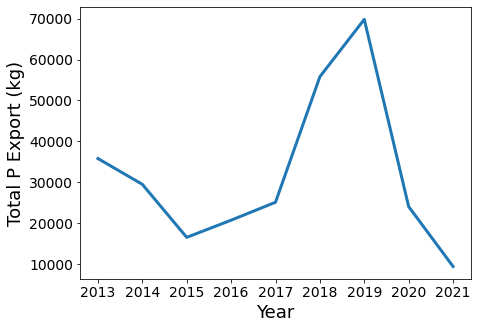

In [23]:
# Plot the total P export by year for the Mendota Watershed

plt.figure(figsize = (7, 5))
plt.plot(year_list, export_by_year, linewidth = 3)
#plt.title("Total Export by Year", fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Total P Export (kg)", fontsize = 18)
plt.xlabel("Year", fontsize = 18)

In [40]:
# Compute the total Phophorus exported over 9 years for each subcatchment

tot_list = [f"TP{i}_tot" for i in range(2013, 2022, 1)]
ag_list = [f"TP{i}_ag" for i in range(2013, 2022, 1)]

sub_catch["TP9yr_tot"] = np.sum(sub_catch[tot_list].values, axis = 1)
sub_catch["TP9yr_ag"] = np.sum(sub_catch[ag_list].values, axis = 1)

In [41]:
# Add the total export of each watershed by year to a new GeoDataFrame; 
# This will be used for plotting the export by year below

sub_total_export = stat_TP_gdf.copy(deep = True)

for j in range(len(sub_total_export)):
    up_COMID = sub_total_export.upstream_COMID.iloc[j]
    if up_COMID != 0:
        upstream_line = sub_total_export[sub_total_export.COMID == up_COMID]
        for (i, year) in enumerate(year_list):
            sub_total_export[f"TP{year}"].loc[j] = sub_total_export[f"TP{year}"].iloc[j] - upstream_line[f"TP{year}"].iloc[0]
            

In [42]:
# Add names to the watersheds

sub_total_export["WS_Name"] = ""

sub_total_export.WS_Name.iloc[0] = "YR1" 
sub_total_export.WS_Name.iloc[1] = "YR2" 
sub_total_export.WS_Name.iloc[2] = "SC1" 
sub_total_export.WS_Name.iloc[3] = "SC2" 
sub_total_export.WS_Name.iloc[4] = "DC" 
sub_total_export.WS_Name.iloc[5] = "PB" 

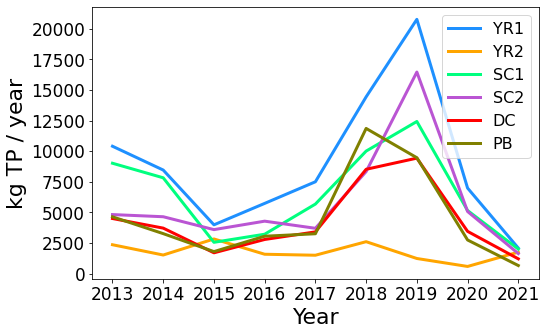

In [30]:
# Plot the subwatershed export by year
# Define colors for each line

colors = ["dodgerblue", "orange", "springgreen", "mediumorchid", "red", "olive"]

plt.figure(figsize = (8,5))
for i in range(6):
    plt.plot(year_list, sub_total_export.iloc[i, 2:11], label = sub_total_export.WS_Name.iloc[i], linewidth = 3, color = colors[i])
    
plt.legend(fontsize = 16)
plt.xlabel("Year", fontsize = 22)
plt.ylabel("kg TP / year", fontsize = 22)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

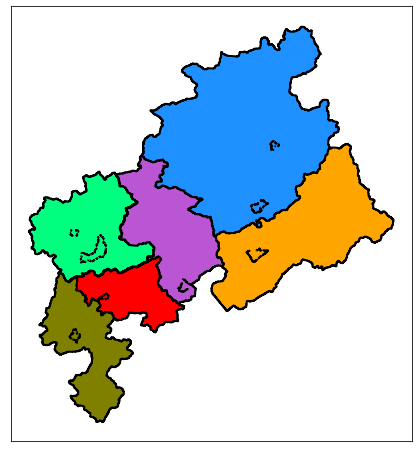

In [44]:
# Plot the watersheds with their corresponding colors
fig, ax = plt.subplots(figsize = (8,8))

for i in range(len(sub_catch)):
    sub_catch[sub_catch.ws_area == sub_catch.ws_area.iloc[i]].plot(ax=ax, color = colors[i], edgecolor = "black", zorder = 50, linewidth = 2)
plt.xticks([])
plt.yticks([])
plt.show()

In [45]:
# Compute the average concentration reported at each station for each year
# concentrations are those at the USGS station at the bottom of the subwatershed

for i in range(len(year_list)):
    sub_catch[f"TP{year_list[i]}_conc_avg"] = 0
    
    for k in range(len(comid_list)):
        comid = comid_list[k]
        stat_id = stat_TP_gdf[stat_TP_gdf.COMID == comid].ID.iloc[0]
        flow_year = flow_data[(flow_data.ID == stat_id) & (flow_data.Date.dt.year == year_list[i])]
        sub_catch[f"TP{year_list[i]}_conc_avg"].loc[comid] = np.average(flow_year.TP.values.astype(float))

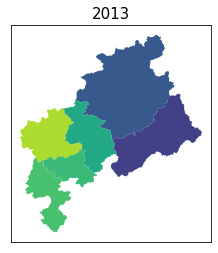

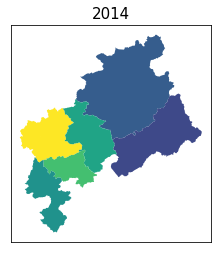

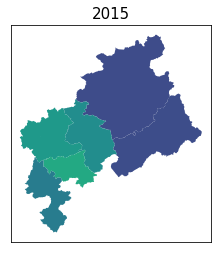

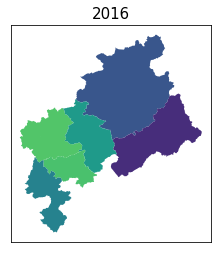

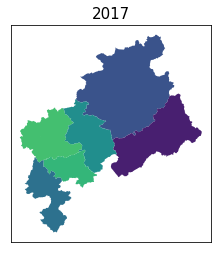

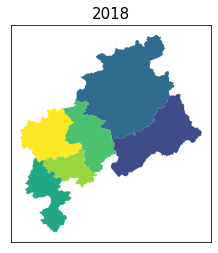

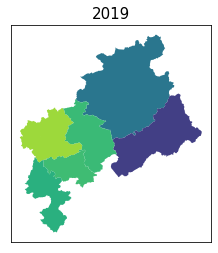

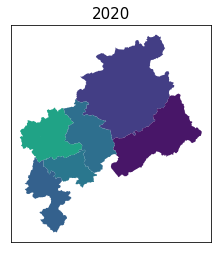

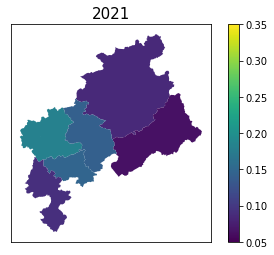

In [32]:
# For each year, plot the average phosphorus concentration at the station with it's corresponding upstream watershed

for i in year_list:
    if i != 2021:
        sub_catch.plot(column = f"TP{i}_conc_avg", legend = False, vmin = 0.05, vmax = .35)
    else:
        sub_catch.plot(column = f"TP{i}_conc_avg", legend = True, vmin = 0.05, vmax = .35)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{i}", fontsize = 15)


In [33]:
# Compute an average concentration over the 9 year span
# concentrations are those at the USGS station at the bottom of the subwatershed

conc_list = [f"TP{i}_conc_avg" for i in range(2013, 2022, 1)]

sub_catch["TP9yr_conc_avg"] = np.average(sub_catch[conc_list].values, axis = 1)


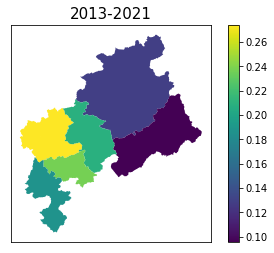

In [34]:
# Plot the average reported concentration over the 9 year span; each year was equally weighted
# concentrations are those at the USGS station at the bottom of the subwatershed

sub_catch.plot(column = f"TP9yr_conc_avg", legend = True)#, vmin = 0, vmax = 70)
plt.xticks([])
plt.yticks([])
plt.title("2013-2021", fontsize = 15)
plt.show()

In [35]:
# Convert the total p export (normalized by weighted area) into a log value for plotting

log_list = [f"TP{i}_log_tot" for i in range(2013, 2022, 1)]
tot_list = [f"TP{i}_tot" for i in range(2013, 2022, 1)]

for i in range(len(log_list)):
    sub_catch[log_list[i]] = np.log10(sub_catch[tot_list[i]].values)

In [36]:
sub_catch["TP9yr_log_tot"] = np.log10(sub_catch.TP9yr_tot)

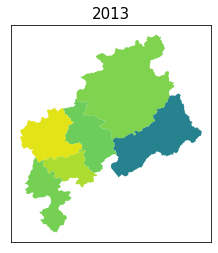

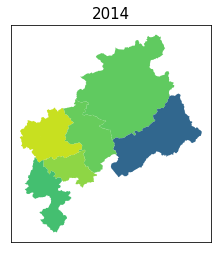

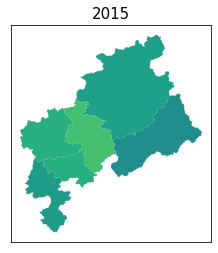

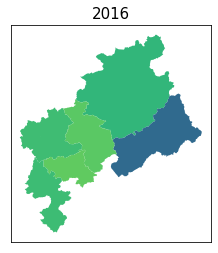

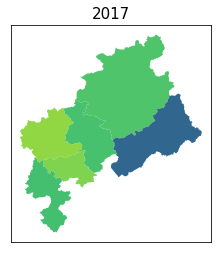

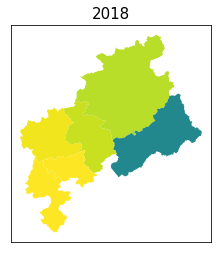

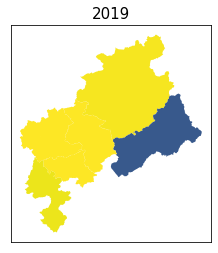

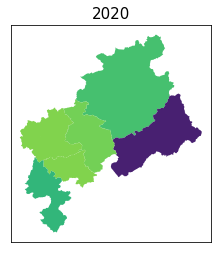

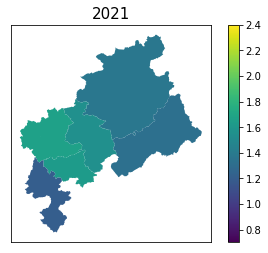

In [38]:
# Plot the total P export per weighted area (kg / km^2) on a log scale for each year
for i in year_list:
    if i != 2021:
        sub_catch.plot(column = f"TP{i}_log_tot", legend = False, vmin = 0.7, vmax = 2.4)
    else:
        sub_catch.plot(column = f"TP{i}_log_tot", legend = True, vmin = 0.7, vmax = 2.4)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{i}", fontsize = 15)


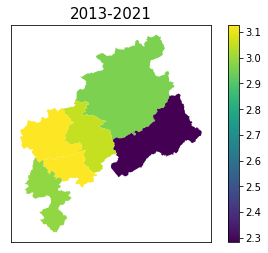

In [37]:
# Plot the total P exported per weighted area (kg / km^2) for a 9 year period on a log scale

sub_catch.plot(column = f"TP9yr_log_tot", legend = True)
plt.xticks([])
plt.yticks([])
plt.title("2013-2021", fontsize = 15)
plt.show()